<a href="https://colab.research.google.com/github/diwakarojha/Tensorflow_Keras/blob/main/6_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional,Dense, LSTM,Embedding, Flatten
from tensorflow.keras.models import Sequential

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [101]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-11-30 09:25:00--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 209.85.234.139, 209.85.234.138, 209.85.234.100, ...
Connecting to drive.google.com (drive.google.com)|209.85.234.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iufgl6c142sd3isnhlstauiq5641lrth/1606728300000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-11-30 09:25:03--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iufgl6c142sd3isnhlstauiq5641lrth/1606728300000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|108.1

In [102]:
data=pd.read_csv('/tmp/songdata.csv')

In [103]:
data.text[1]

"Take it easy with me, please  \nTouch me gently like a summer evening breeze  \nTake your time, make it slow  \nAndante, Andante  \nJust let the feeling grow  \n  \nMake your fingers soft and light  \nLet your body be the velvet of the night  \nTouch my soul, you know how  \nAndante, Andante  \nGo slowly with me now  \n  \nI'm your music  \n(I am your music and I am your song)  \nI'm your song  \n(I am your music and I am your song)  \nPlay me time and time again and make me strong  \n(Play me again 'cause you're making me strong)  \nMake me sing, make me sound  \n(You make me sing and you make me)  \nAndante, Andante  \nTread lightly on my ground  \nAndante, Andante  \nOh please don't let me down  \n  \nThere's a shimmer in your eyes  \nLike the feeling of a thousand butterflies  \nPlease don't talk, go on, play  \nAndante, Andante  \nAnd let me float away  \n  \nI'm your music  \n(I am your music and I am your song)  \nI'm your song  \n(I am your music and I am your song)  \nPlay me

In [104]:
def tokenize_corpus(corpus,num_words=-1):
  if num_words>1:
    tokenizer=Tokenizer(num_words)
  else:
    tokenizer=Tokenizer()

  tokenizer.fit_on_texts(corpus)
  #corpus_seq=tokenizer.texts_to_sequences(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus


In [105]:
# corpus=data.text[0:3]
# num_words=300
# tokenizer=Tokenizer(num_words)
# tokenizer.fit_on_texts(corpus)
# corpus_seq=tokenizer.texts_to_sequences(corpus)

In [106]:
datas=pd.DataFrame(data.loc[:250,:])
corpus=create_lyrics_corpus(datas,'text')
tokenizer=tokenize_corpus(corpus)
total_words=len(tokenizer.word_index)+1
print(total_words)
print(corpus[:10])
print(tokenizer.word_index)

4160
['look at her face its a wonderful face', 'and it means something special to me', 'look at the way that she smiles when she sees me', 'how lucky can one fellow be', 'shes just my kind of girl she makes me feel fine', 'who could ever believe that she could be mine', 'shes just my kind of girl without her im blue', 'and if she ever leaves me what could i do what could i do', 'and when we go for a walk in the park', 'and she holds me and squeezes my hand']
{'the': 1, 'i': 2, 'you': 3, 'a': 4, 'and': 5, 'to': 6, 'me': 7, 'it': 8, 'in': 9, 'my': 10, 'of': 11, 'that': 12, 'your': 13, 'im': 14, 'for': 15, 'all': 16, 'on': 17, 'love': 18, 'so': 19, 'is': 20, 'be': 21, 'we': 22, 'youre': 23, 'when': 24, 'but': 25, 'dont': 26, 'like': 27, 'just': 28, 'its': 29, 'with': 30, 'no': 31, 'know': 32, 'now': 33, 'do': 34, 'la': 35, 'what': 36, 'have': 37, 'got': 38, 'can': 39, 'was': 40, 'take': 41, 'one': 42, 'if': 43, 'down': 44, 'get': 45, 'yeah': 46, 'never': 47, 'time': 48, 'she': 49, 'see': 

In [107]:
sequences=[]

for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    ngram_seq=token_list[:i+1]
    sequences.append(ngram_seq)

max_seq_len=max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences,maxlen=max_seq_len,padding='pre'))

input_seq,labels=sequences[:,:-1],sequences[:,-1:]
one_hot_labels=to_categorical(labels,num_classes=total_words)

In [108]:
model=Sequential()
model.add(Embedding(total_words,64,input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Flatten())
model.add(Dense(total_words,activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 19, 64)            266240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                13600     
_________________________________________________________________
flatten_4 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4160)              170560    
Total params: 450,400
Trainable params: 450,400
Non-trainable params: 0
_________________________________________________________________


In [110]:
history=model.fit(input_seq,one_hot_labels,epochs=100,verbose=1)

Epoch 1/100
1564/1564 [==============================] - 15s 10ms/step - loss: 5.6685 - accuracy: 0.0691
Epoch 2/100
1564/1564 [==============================] - 15s 10ms/step - loss: 5.5037 - accuracy: 0.0951
Epoch 3/100
1564/1564 [==============================] - 15s 10ms/step - loss: 5.3411 - accuracy: 0.1144
Epoch 4/100
1564/1564 [==============================] - 15s 9ms/step - loss: 5.1828 - accuracy: 0.1293
Epoch 5/100
1564/1564 [==============================] - 16s 10ms/step - loss: 5.0383 - accuracy: 0.1420
Epoch 6/100
1564/1564 [==============================] - 15s 10ms/step - loss: 4.8746 - accuracy: 0.1546
Epoch 7/100
1564/1564 [==============================] - 15s 10ms/step - loss: 4.7029 - accuracy: 0.1707
Epoch 8/100
1564/1564 [==============================] - 15s 9ms/step - loss: 4.5563 - accuracy: 0.1846
Epoch 9/100
1564/1564 [==============================] - 15s 9ms/step - loss: 4.4281 - accuracy: 0.1957
Epoch 10/100
1564/1564 [==============================] - 

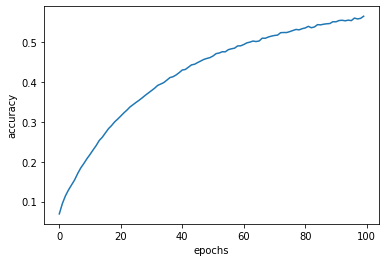

In [111]:
data='accuracy'
plt.plot(history.history[data])
plt.xlabel('epochs')
plt.ylabel(data)
plt.show()

In [117]:
starter="night is beautiful how to"
next_words=100
for _ in range(next_words):
  token_list=tokenizer.texts_to_sequences([starter])[0]
  token_list=np.array(pad_sequences([token_list],maxlen=max_seq_len-1,padding='pre'))
  #predicted=np.argmax(model.predict([token_list]),axis=-1)
  predicted_probs=model.predict([token_list])[0]
  predicted=np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  new_word=""
  for word,index in tokenizer.word_index.items():
    if index == predicted:
      #print(index)
      new_word = word
      break
  starter = starter + " " + new_word
starter



'night is beautiful how to say goodbye together beat that then myself was dawning down phone across me to tune of me with me in your back morning moon stone know that you are my always felt tantric time or wet me that for it to me that she doesnt judge of age rainy side cmon fool like want to meet everybodys bare shine heaven on lizzy be such on their chance on that shouting youll lose a dreamworld i dont it have fixer fashion came hard clear enough of em to fortune by every smokin soul yonder cause it isnt me that beats by'

In [113]:
seed_text = "to the beach with my"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

to the beach with my mind is fine for me droolin with my blood matters you ever let it out of a similiar heartbreaker chance ahead ahead that i know that i heart how it up aint gonna do i hold it up youre far away ahhaha act start it never done bright to do and your own pride kissin song chiquitita leavin baited hearts take tails the other supposed pan backseat that cowboys hurdygurdy happiest case dance nancy nancy bright for able meet wed have jamas a helping hand way check it hey doll taste of head hey hey call world song will forever
